In [1]:
import os
import cv2
import torch
import random
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from tensorflow.keras.utils import to_categorical
torch.manual_seed(0)


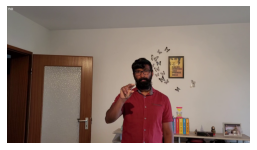

In [2]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('C:\\Users\\ritth\\code\\Data\\thirty_frames')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 1)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'C:\\Users\\ritth\\code\\Data\\thirty_frames\\{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'C:\\Users\\ritth\\code\\Data\\thirty_frames\\{selected_class_Name}\\{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints(results):
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

# df

In [7]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "C:\\Users\\ritth\\code\\Data\\thirty_frames"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = np.array(["mother", "meet", "no", "hello", "like"])

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video. 
            success, frame = video_reader.read()

            image, results = mediapipe_detection(frame, holistic)
            
           # Draw landmarks
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)

            # Check if Video frame is not successfully read then break the loop
            if not success:
                break
            
            # Append the keypoints into the frames list
            frames_list.append(keypoints)

    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    
    # Converting the list to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


In [10]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: mother
Extracting Data of Class: meet
Extracting Data of Class: no
Extracting Data of Class: hello
Extracting Data of Class: like


In [11]:
features.shape, labels.shape

((191, 30, 126), (191,))

In [ ]:
import tensorflow as tf

In [ ]:
features = tf.convert_to_tensor(features)
labels= tf.convert_to_tensor(labels)

In [12]:
fully= zip(features, labels)
fully

In [13]:
import pandas as pd

In [14]:
data = pd.DataFrame(fully, columns = ['features','labels'])

print(data)
print(type(data))

                                              features  labels
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0
..                                                 ...     ...
186  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       4
187  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       4
188  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       4
189  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       4
190  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       4

[191 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [17]:
data.shape

(191, 2)

In [18]:
data["features"]

0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
186    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
187    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
188    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
189    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
190    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: features, Length: 191, dtype: object

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [21]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0, stratify= data["labels"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.shape, test_data.shape

((152, 2), (39, 2))

In [22]:
class LandmarkDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        target = torch.tensor(self.df.values[:, 0]).type(torch.LongTensor)
        features = torch.tensor(self.df.values[:, 1:], dtype = torch.float)
        return features[index], target[index]
    
    
train_set = LandmarkDataset(train_data)
test_set = LandmarkDataset(test_data)
len(train_set), len(test_set)

(152, 39)

In [23]:
trainloader = DataLoader(train_set, batch_size = 16, shuffle = True)
testloader = DataLoader(test_set, batch_size = 16, shuffle = False)

In [ ]:
x

In [24]:
x, y = iter(trainloader).next()
x.shape, y.shape

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [26]:
n_features = data.shape[1] - 1
hidden_size = [32, 16]
n_classes = len(data["labels"].unique())
class MLP(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.output = nn.Linear(hidden_size[1], n_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.output(x), dim = 1)


# Initialize the model
model = MLP(n_features, n_classes, hidden_size)

In [27]:
learning_rate = 0.001
epochs = 120

optimizer = Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.75
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    # training
    for x_train_batch, y_train_batch in trainloader:
        
        optimizer.zero_grad()

        # forward pass
        scores = model(x_train_batch)
        train_preds = torch.argmax(scores.detach(), dim=1)

        # loss
        train_loss = criterion(scores, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            
            # logits
            test_scores = model(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_scores, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_scores, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_loss / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.state_dict(), "model.pth")
            
           
            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("draw.jpg", dpi = 200)

plt.show()

Epoch 1/120


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

# df_train

In [ ]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "C:\\Users\\ritth\\code\\Data\\lstm_video\\train"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = np.array(["mother", "meet", "no", "hello", "like"])

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video. 
            success, frame = video_reader.read()

            image, results = mediapipe_detection(frame, holistic)
            
           # Draw landmarks
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)

            # Check if Video frame is not successfully read then break the loop
            if not success:
                break
            
            # Append the keypoints into the frames list
            frames_list.append(keypoints)

    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list


In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    
    # Converting the list to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [ ]:
features.shape, labels.shape
fully_train = zip(features, labels)

In [ ]:
import pandas as pd
df_train = pd.DataFrame(fully_train, columns = ['features','labels'])

print(df_train)
print(type(df_train))

# df_test

In [ ]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "C:\\Users\\ritth\\code\\Data\\lstm_video\\test"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = np.array(["mother", "meet", "no", "hello", "like"])

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video. 
            success, frame = video_reader.read()

            image, results = mediapipe_detection(frame, holistic)
            
           # Draw landmarks
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)

            # Check if Video frame is not successfully read then break the loop
            if not success:
                break
            # Append the keypoints into the frames list
            frames_list.append(keypoints)

    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list


In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    
    # Converting the list to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

In [ ]:
features.shape, labels.shape
fully_test = zip(features, labels)

In [ ]:
import pandas as pd
df_test = pd.DataFrame(fully_test, columns = ['features','labels'])

print(df_test)
print(type(df_test))

# finally

In [ ]:
def next_stock_batch(batch_size, n_steps, df_base, n_features):
    t_max = df_base.shape[0]
    print(t_max)

    x = np.zeros((batch_size, n_steps, n_features))
    y = np.zeros((batch_size, n_steps))
    starting_points = np.random.randint(0, t_max-n_steps-1, size=batch_size)    
    print(starting_points)
    
    #We create the batches for x using all time series (8) between t and t+n_steps 
    for i, sp in enumerate(starting_points):
        #print(df)
        app = df[n_steps]
        print(n_steps)
        x[i] = df[sp + n_steps]
        y[i] = df_base[sp + 1: sp + n_steps + 1, 1]
       

    return x, y

x, y = next_stock_batch(32, 2, df_train, df.shape[1])

print()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, seq_len):
        super().__init__()
        self.num_layer = num_layers
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.batch_size * self.hidden_size, 500)
        self.fc2 = nn.Linear(500, 1)
    

    def forward(self, x):
        h0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))
        c0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h0, c0))
        last_hidden = hn[-1]
    

        x = F.relu(last_hidden.flatten()) # added this line, you can activate also the last hidden layer, for better performance
        output = F.relu(self.fc1(x))
        return self.fc2(output)


model = LSTM(2, 128, 10, 32, 20)

In [ ]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [ ]:
n_iterations = 500
printing_gap = 50
train_losses = []
test_losses = []

for iter in range(n_iterations):
    
    model.train()  
    # Get a batch
    x_train, y_train = next_stock_batch(32, 5, df_train, df.shape[1])

    # make into tensor
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float().flatten()


    y_pred = model(x_train)
    loss = criterion(y_pred, y_train.view(1, -1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.detach().item())


    if iter % printing_gap == 0:
        print(f'Epoch: {iter + 1}/{n_iterations}, MSE: {loss.item()}')

    model.eval()
    with torch.no_grad():
        x_test, y_test = next_stock_batch(32, 5, df_test, df.shape[1])
        x_test = torch.from_numpy(x_test).float()
        y_test = torch.from_numpy(y_test).float().flatten()

        test_pred = model(x_test)
        test_loss = criterion(test_pred, y_test)
        test_losses.append(test_loss.detach().item())
    scheduler.step()


plt.plot(train_losses, label= "Train Loss")
plt.plot(test_losses, label= "Test Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")